In [1]:
import os, sys, inspect

import datetime
#rcParams['font.sans-serif'] = ['Tahoma']

import math
import numpy as np
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'

working_dir = os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(working_dir)
sys.path.insert(0, parent_dir)

from scripts_py import global_parameters as gp
from scripts_py import utility_functions as uf
from scripts_py import analyse_mrna_display as amd
from scripts_py.analyse_mrna_display import Selection

%load_ext autoreload
%autoreload 2

In [2]:
def SingleSelectionRoundSummary(fastq_file_path):
#returns a list of lists with peptide-sequences and their frequencies, sorted by frequency in descending order
    
    RawDataFile = open(fastq_file_path, 'r')
    lines = RawDataFile.readlines()
    RawDataFile.close
    
    #start_sequence = 'ATG' # Met codon
    #stop_sequence = 'TGCGGCAGC'# Akane seams to have trimmed siquences
    #stop_sequence = 'TAG' # amber stop codon
    
#     start_sequence = 'TAATACGACTCACTATAGGGTTAACTTTAAGAAGGAGATATACATATG'  # NNK - T7g10M.F48
#     stop_sequence = 'TGCGGCAGCGGCAGCGGCAGCTAGGACGGGGGGCGGAAA' #NNK - CGS3an13.R39
    stop_sequence = 'CATATGTATATCTCCTTCTTAAAGTT'  # NNK - T7g10M.F48 truncated reverse complement
    start_sequence = 'CCCCCGTCCTAGCTGCCGCTGCCGCTGCCGCA' #NNK - CGS3an13.R39 reverse complement

    #start_sequence = 'TAATACGACTCACTATAGGGTTGAACTTTAAGTAGGAGATATATCCATG'   #NNU - T7-CH-F49
    #stop_sequence = 'TGTGGGTCTGGGTCTGGGTCTTAGGACGGGGGGCGGAAA'  #NNU - CGS3-CH-R39
    
    SingleSelectionRoundSummary = {}
    #creates empty SingleSelectionRoundSummary dictionary to store the results from a single round of selection
    #SingleSelectionRoundSummary = {peptideY:    {coding_sequence_YZ:    Occurrence_YZ}}
        
    #populates SingleSelectionRoundSummary dictionary with the results from a single round of selection

    for i, line in enumerate(lines):
        if (
            (start_sequence in line)
            and (stop_sequence in line)
            ):

            coding_sequence = uf.get_coding_sequence(
                dna_sequence=line,
                quality_sequence=lines[i + 2],
                cdna_min_length=gp.CDNA_MIN_LENGTH,
                cdna_max_length=gp.CDNA_MAX_LENGTH,
                start_sequence=start_sequence,
                stop_sequence=stop_sequence,
                quality_score=gp.QUALITY_SCORE,
                )
            
#             DNAcoding_sequence(line, lines[i + 2], start_sequence, stop_sequence)
#             counter += 1
            if coding_sequence != None:
                coding_sequence = uf.get_reverse_complement(coding_sequence)
                peptide = uf.translate(coding_sequence)
                if peptide not in SingleSelectionRoundSummary:
                    SingleSelectionRoundSummary[str(peptide)] = {str(coding_sequence) : 1}
                else:
                    if coding_sequence not in SingleSelectionRoundSummary[str(peptide)]:
                        SingleSelectionRoundSummary[str(peptide)][str(coding_sequence)] = 1
                    else:
                        SingleSelectionRoundSummary[str(peptide)][str(coding_sequence)] += 1

    return SingleSelectionRoundSummary

In [3]:
def Completedisplay_summary(data_directory_path):
# returns a display_summary dictionary with the following structure
# display_summary = {SelectionRound_X:    {peptideXY:    {CodingDNA_XYZ:    Occurrence_XYZ}}}

    Completedisplay_summary = {}
    # creates empty display_summary dictionary to store the results from all the rounds of selection

    for file in os.listdir(data_directory_path):
        
        file_path = os.path.join(data_directory_path, file)
          
        if file.endswith('.fastq'): # this conditional is necessary; without it some shit appears in the beginning of the file list
            cycle_numberFirstDigit = file[file.find('.')-2]
            cycle_numberSecondDigit = file[file.find('.')-1]
            if cycle_numberFirstDigit == '0':
                cycle_number = int(cycle_numberSecondDigit)
            elif cycle_numberFirstDigit != '0':
                cycle_number = int(file[file.find('.')-2 : file.find('.')])
        #(1.A) extracts the round number from the file name (file name should have two digit number before full stop — '00.') 
                
            SelectionRoundSummary = SingleSelectionRoundSummary(file_path)
            #(1.B) extracts single round results       
            Completedisplay_summary[cycle_number] = SelectionRoundSummary
            #(1.C) populate ConcatenatedResultsList
            
    return Completedisplay_summary

In [4]:
def peptidesOccurrences_BY_Round(data_directory_path):
    display_summary = Completedisplay_summary(data_directory_path)
    
    peptidesOccurrences_BY_Round = {}
    for Round in display_summary:
        peptidesOccurrences_IN_Round = {}
        for peptide in display_summary[Round]:
            peptidesOccurrences_IN_Round[peptide] = sum(display_summary[Round][peptide].values())
        peptidesOccurrences_BY_Round[Round] = peptidesOccurrences_IN_Round
        
    return peptidesOccurrences_BY_Round

In [5]:
def DNAsOccurrences_BY_Round(data_directory_path):
    display_summary = Completedisplay_summary(data_directory_path)
    
    DNAsOccurrences_BY_Round = {}
    for Round in display_summary:
        DNAsOccurrences_IN_Round = {}
        for peptide in display_summary[Round]:
            for DNA in display_summary[Round][peptide]:
                DNAsOccurrences_IN_Round[DNA] = display_summary[Round][peptide][DNA]
        DNAsOccurrences_BY_Round[Round] = DNAsOccurrences_IN_Round

    return DNAsOccurrences_BY_Round

In [6]:
def TotalReads_BY_Round(data_directory_path):
    display_summary = Completedisplay_summary(data_directory_path)
    peptides_BY_Round = peptidesOccurrences_BY_Round(data_directory_path)
    
    TotalReads_BY_Round = {}
    for Round in display_summary:
        TotalReads_BY_Round[Round] = sum(peptides_BY_Round[Round].values())
        
    return TotalReads_BY_Round

In [7]:
def BaseRoundSortedpeptidesList(data_directory_path, base_cycle):
    peptides_BY_Round = peptidesOccurrences_BY_Round(data_directory_path)  
            
    peptidesOccurrencesInBaseRound = peptides_BY_Round[base_cycle]
    BaseRoundSortedpeptidesList = sorted(peptidesOccurrencesInBaseRound, key = peptidesOccurrencesInBaseRound.get, reverse = True)
    
    return BaseRoundSortedpeptidesList

In [8]:
def peptidesRank_IN_BaseRound(data_directory_path, base_cycle):
    peptides_BY_Round = peptidesOccurrences_BY_Round(data_directory_path)
    BaseRoundSortedpeptides = BaseRoundSortedpeptidesList(data_directory_path, base_cycle)
#         data_directory_path=data_directory_path,
#         base_cycle=base_cycle,
#         cdna_min_length=gp.CDNA_MIN_LENGTH,
#         cdna_max_length=gp.CDNA_MAX_LENGTH,
#         start_sequence=gp.START_SEQUENCE,
#         stop_sequence=gp.STOP_SEQUENCE,
#         quality_score=gp.QUALITY_SCORE,
    
    BasepeptideCount = 0
    peptideRank = 1
    
    peptidesRank_IN_BaseRound = {}
    
    for peptide in BaseRoundSortedpeptides:
        peptideCount = peptides_BY_Round[base_cycle][peptide]
        if peptideCount < BasepeptideCount:
            peptideRank += 1
        
        peptidesRank_IN_BaseRound[peptide] = peptideRank
        BasepeptideCount = peptideCount
        
    return peptidesRank_IN_BaseRound

In [9]:
def display_summaryReport(data_directory_path, base_cycle, n_top_peptides, file_name):
    
    today = uf.get_todays_date() 
    
    display_summaryFileNameCSV = str(today) + 'display_summary' + file_name + '.csv'
    display_summaryReportFile = open(display_summaryFileNameCSV, 'w')
    
    display_summary = Completedisplay_summary(data_directory_path)
    SortedRoundsList = sorted(display_summary.keys())
    
    peptides_BY_Round = peptidesOccurrences_BY_Round(data_directory_path)
    Totalpeptides_BY_Round = TotalReads_BY_Round(data_directory_path)
    
    BaseRoundSortedpeptides = BaseRoundSortedpeptidesList(data_directory_path, base_cycle)
    BaseRoundTopSortedpeptides = BaseRoundSortedpeptides[0 : (n_top_peptides)]
    
    AlaScanpeptidesKDs = {'VWDPRTFYLSRI' : '3', 'AWDPRTFYLSRI' : '8', 'VADPRTFYLSRI' : '413',
                        'VWAPRTFYLSRI' : '28', 'VWDARTFYLSRI' : '12', 'VWDPATFYLSRI' : '2',
                        'VWDPRAFYLSRI' : '12', 'VWDPRTAYLSRI' : '187', 'VWDPRTFALSRI' : '>1000',
                        'VWDPRTFYASRI' : '79', 'VWDPRTFYLARI' : '9', 'VWDPRTFYLSAI' : '468',
                        'VWDPRTFYLSRA' : '6'
                       }
    
    AlaScanpeptidescDNAs = {'VWDPRTFYLSRI' : 'GTGTGGGATCCGCGCACCTTTTATCTGAGCCGCATT',
                            'AWDPRTFYLSRI' : 'GCGTGGGATCCGCGCACCTTTTATCTGAGCCGCATT',
                            'VADPRTFYLSRI' : 'GTGGCGGATCCGCGCACCTTTTATCTGAGCCGCATT',
                            'VWAPRTFYLSRI' : 'GTGTGGGCGCCGCGCACCTTTTATCTGAGCCGCATT',
                            'VWDARTFYLSRI' : 'GTGTGGGATGCGCGCACCTTTTATCTGAGCCGCATT',
                            'VWDPATFYLSRI' : 'GTGTGGGATCCGGCGACCTTTTATCTGAGCCGCATT',
                            'VWDPRAFYLSRI' : 'GTGTGGGATCCGCGCGCGTTTTATCTGAGCCGCATT',
                            'VWDPRTAYLSRI' : 'GTGTGGGATCCGCGCACCGCGTATCTGAGCCGCATT',
                            'VWDPRTFALSRI' : 'GTGTGGGATCCGCGCACCTTTGCGCTGAGCCGCATT',
                            'VWDPRTFYASRI' : 'GTGTGGGATCCGCGCACCTTTTATGCGAGCCGCATT',
                            'VWDPRTFYLARI' : 'GTGTGGGATCCGCGCACCTTTTATCTGGCGCGCATT',
                            'VWDPRTFYLSAI' : 'GTGTGGGATCCGCGCACCTTTTATCTGAGCGCGATT',
                            'VWDPRTFYLSRA' : 'GTGTGGGATCCGCGCACCTTTTATCTGAGCCGCGCG'
                            }
    
    BaseRoundpeptidesRank = peptidesRank_IN_BaseRound(data_directory_path, base_cycle)
    
    display_summaryReportFile.write('peptide sequence' + ',')
    for Round in SortedRoundsList:
        display_summaryReportFile.write('round # ' + str(Round) + ' occurrence (#)' + ',')
    display_summaryReportFile.write('\n')
    
    for peptide in BaseRoundTopSortedpeptides:
        display_summaryReportFile.write(peptide + ',')
        for Round in SortedRoundsList:
            display_summaryReportFile.write(str(peptides_BY_Round[Round].get(peptide, 0)) + ',')
        display_summaryReportFile.write('\n')
        
    display_summaryReportFile.write('total #' + ',')
    for Round in SortedRoundsList:
        display_summaryReportFile.write(str(Totalpeptides_BY_Round[Round]) + ',')
    display_summaryReportFile.write('\n\n\n')
    
    display_summaryReportFile.write('peptide sequence' + ',')
    for Round in SortedRoundsList:
        display_summaryReportFile.write('round # ' + str(Round) + ' fraction (%)' + ',')
    display_summaryReportFile.write('\n')
    
    for peptide in BaseRoundTopSortedpeptides:
        display_summaryReportFile.write(peptide + ',')
        for Round in SortedRoundsList:
            peptideFraction = float((peptides_BY_Round[Round].get(peptide, 0)))/float(Totalpeptides_BY_Round[Round])
            display_summaryReportFile.write('{:.3%}'.format(peptideFraction) + ',')
        display_summaryReportFile.write('\n')
            
    display_summaryReportFile.close()
        
#-------------------------------------------------------------------------------
   
    # Create a figure of size 8x6 inches, 500 dots per inch
    plt.figure(figsize = (8, 6),
               dpi = 500)
    # Create 'ggplot' style
    plt.style.use('fivethirtyeight')
    # Create a new subplot from a grid of 1x1
    Graph = plt.subplot(1, 1, 1)
    
    # Map colours onto lines
    # n_top_peptides was replaced with 15, to make gradient more pronounced
    cNorm  = matplotlib.colors.Normalize(vmin = 0,
                                         vmax = 15 - 1)
    scalarMap = matplotlib.cm.ScalarMappable(norm = cNorm,
                                             cmap = 'gist_rainbow')
    
    Xs = []
    Ys = []
    
    for peptide in BaseRoundSortedpeptides:
        if peptide in AlaScanpeptidesKDs:
    
    #for peptide in BaseRoundTopSortedpeptides:
            peptidesFractions_BY_Round = []
            for Round in SortedRoundsList:
                peptidesFractions_BY_Round += [float((peptides_BY_Round[Round].get(peptide, 0)))/float(Totalpeptides_BY_Round[Round])]

            x = SortedRoundsList
            y = peptidesFractions_BY_Round
            Xs += x
            Ys += y

            # Set peptideColour
            #peptideColour = scalarMap.to_rgba(BaseRoundTopSortedpeptides.index(peptide))

            Formatedpeptide = ''
            for i in peptide:
                if i != 'A':
                    Formatedpeptide += i.lower()
                else:
                    Formatedpeptide += i
                    
            cDNA = AlaScanpeptidescDNAs[peptide]
            cDNAATCount = uf.get_au_count(cDNA)
            cDNALabel = uf.format_sequence_based_on_mismatches('GTTTGGGATCCGAGGACGTTTTATTTGTCTAGGATT', cDNA)

            peptideRank = str(BaseRoundpeptidesRank[peptide])
            #peptideColour = scalarMap.to_rgba(peptideRank)
            peptideColour = scalarMap.to_rgba(BaseRoundTopSortedpeptides.index(peptide))
            peptideKD = AlaScanpeptidesKDs[peptide]

            peptideLabel = (cDNALabel + '\n' +
                            'A/T count ' + str(cDNAATCount) + '\n' +
                            '(' + peptideRank + ', ' + peptideKD +' nM) ' + Formatedpeptide)

            plt.plot(x, y,
                     'o-',
                     c = peptideColour,
                     lw = 2.0,
                     ms = 4.0,
                     mew = 0.1,
                     mec = '#191919',
                     label = peptideLabel)
    
    XMin = min(Xs) - 0.05*(max(Xs) - min(Xs))
    XMax = max(Xs) + 0.05*(max(Xs) - min(Xs))
    YMin = min(Ys) - 0.05*(max(Ys) - min(Ys))
    YMax = max(Ys) + 0.05*(max(Ys) - min(Ys))
    
    plt.axis([XMin, XMax, YMin, YMax])
    
    plt.xticks([0, 1, 2],
               ['Input\nLibrary', 'Pre-Selection\nLibrary', 'Post-Selection\nLibrary'],
               fontsize = 10)
    #plt.xlabel('Selection Round #',
    #           fontsize = 10)
    
    plt.yticks(fontsize = 10)       
    plt.ylabel('peptide Fraction',
               fontsize = 10)
    
    legend = plt.legend(#BaseRoundTopSortedpeptides,
                        title = 'cyclic-peptide random region',
                        loc = 'upper center',
                        bbox_to_anchor = (0.5, -0.15),
                        fancybox = True,
                        shadow = False,
                        fontsize = 10,
                        ncol = 2)
    
    Graph.get_legend().get_title().set_size('small')
    
    display_summaryFileNamePNG = str(today) + 'display_summary' + file_name + '.png'
    
    plt.savefig(display_summaryFileNamePNG,
                bbox_extra_artists = [legend],
                bbox_inches = 'tight',
                dpi = 300)
    plt.show()
    plt.close()

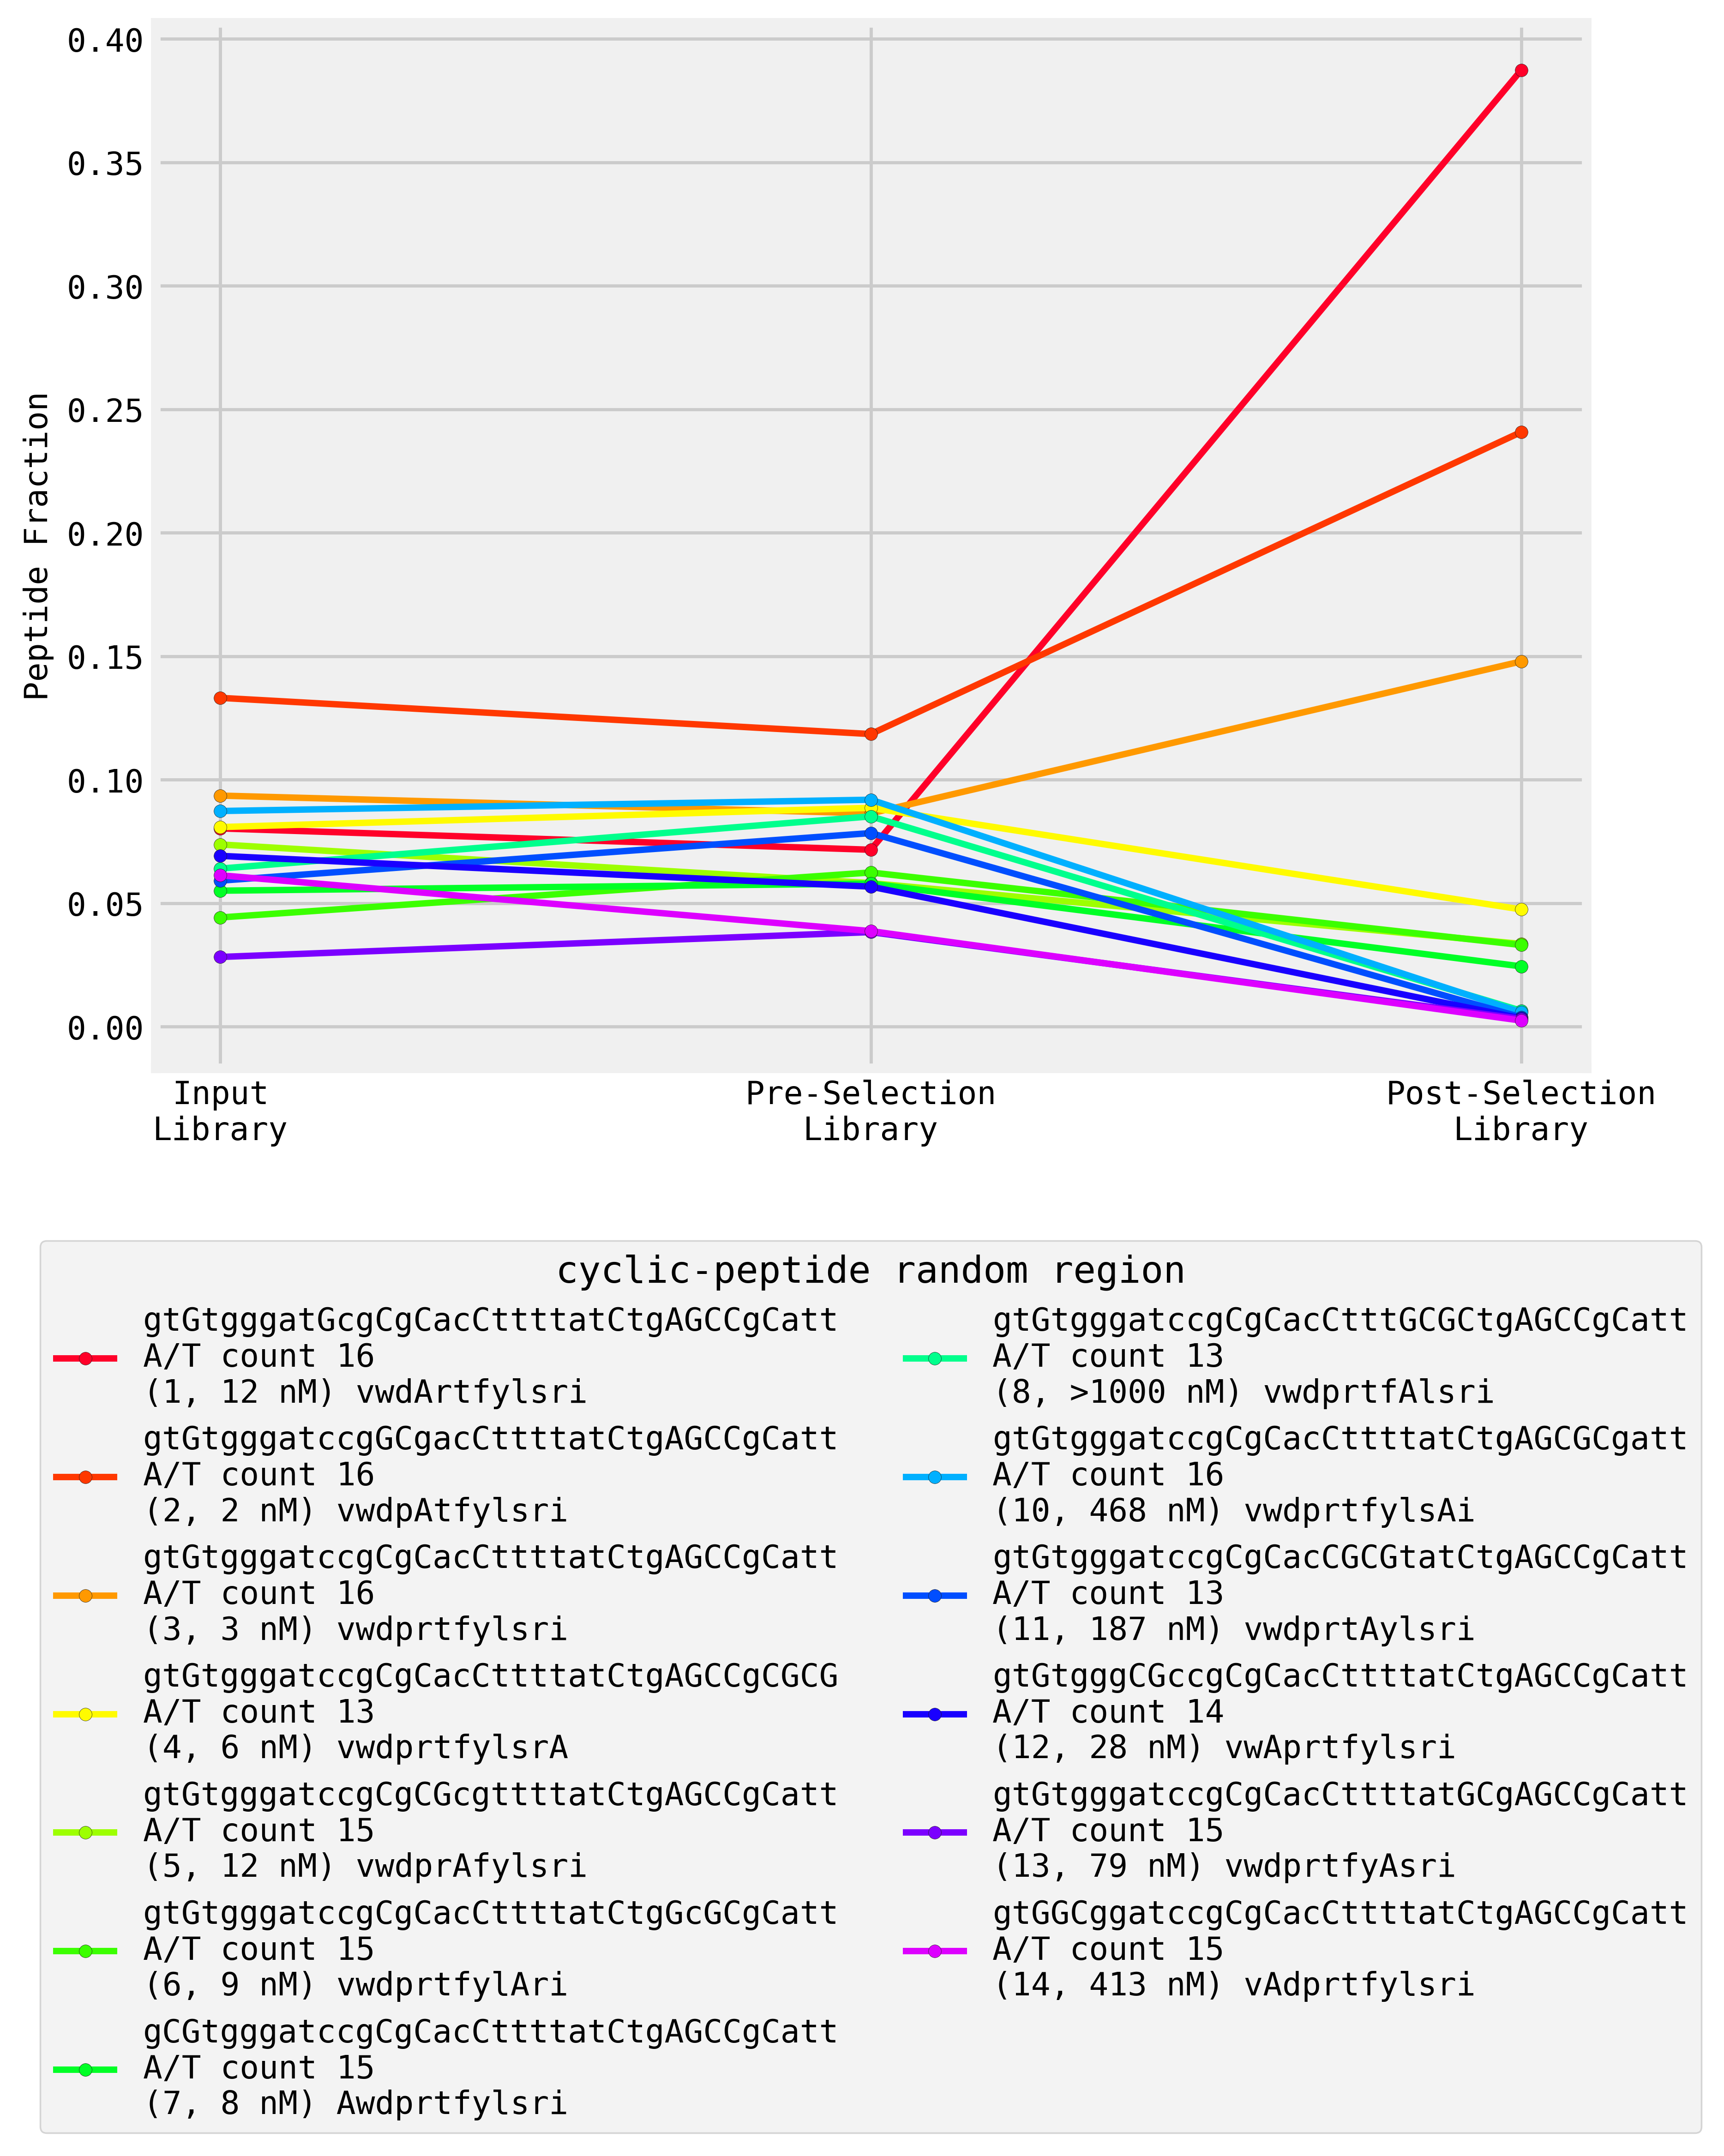

In [10]:
data_directory_path = '../data/ala_scan/'
base_cycle = 2
TopNpeptidesNumber = 100
SummaryFileName = 'Paper02_AlaScan_I'

display_summaryReport(data_directory_path, base_cycle, TopNpeptidesNumber, SummaryFileName)